In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tifffile as tif
import yaml
import os

import carreno.nn.unet
import carreno.nn.metrics as mtc
import carreno.pipeline.pipeline
import carreno.processing.transforms as tfs
import carreno.utils.array
plt.rcParams.update({'figure.autolayout': True})

%load_ext autoreload
%autoreload 2

# Data

In [22]:
if not os.path.exists('config.yml'):
    os.chdir('..')

config = {}
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

inp_dir = config['VOLUME']['input']
rlinp_dir = config['VOLUME']['rl_input']
tar_dir = config['VOLUME']['target']
wei_dir = config['VOLUME']['weight']
psf_dir = config['DIR']['psf']
mod_dir = config['DIR']['model']

psf = tif.imread(os.path.join(psf_dir, "Averaged PSF.tif"))
vx1 = tif.imread(os.path.join(inp_dir, config['TRAINING']['evaluation'][0] + ".tif"))
vy1 = tif.imread(os.path.join(tar_dir, config['TRAINING']['evaluation'][0] + ".tif"))
vw1 = tif.imread(os.path.join(wei_dir, config['TRAINING']['evaluation'][0] + ".tif"))
vx2 = tif.imread(os.path.join(inp_dir, config['TRAINING']['evaluation'][1] + ".tif"))
vy2 = tif.imread(os.path.join(tar_dir, config['TRAINING']['evaluation'][1] + ".tif"))
vw2 = tif.imread(os.path.join(wei_dir, config['TRAINING']['evaluation'][1] + ".tif"))

ax1, __, __ = tfs.Standardize().apply(vx1)
ax2, __, __ = tfs.Standardize().apply(vx2)

vx1v2 = tif.imread(os.path.join(rlinp_dir, config['TRAINING']['evaluation'][0] + ".tif"))
vx2v2 = tif.imread(os.path.join(rlinp_dir, config['TRAINING']['evaluation'][1] + ".tif"))
ax1v2, __, __ = tfs.Standardize().apply(vx1v2)
ax2v2, __, __ = tfs.Standardize().apply(vx2v2)

z = 8
dice         = mtc.Dice().coefficient
cldice3D     = mtc.ClDice(    iters=10, ndim=3, mode=2)
dicecldice3D = mtc.DiceClDice(iters=10, ndim=3, mode=2).coefficient
loss_fn      = mtc.ClDiceAdaptiveWingLoss(iters=10, ndim=3, mode=2).loss

def eval(x, y):
    tx = tf.expand_dims(tf.convert_to_tensor(x, dtype=tf.float32), 0)
    ty = tf.expand_dims(tf.convert_to_tensor(y, dtype=tf.float32), 0)
    dc    = dice        (tx, ty)
    dcldc = dicecldice3D(tx, ty)
    print("DC {}; DCLDC {}".format(dc, dcldc))

def evalw(x, y, w):
    tx = tf.expand_dims(tf.convert_to_tensor(x, dtype=tf.float32), 0)
    ty = tf.expand_dims(tf.convert_to_tensor(y, dtype=tf.float32), 0)
    tw = tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(w, dtype=tf.float32), 0), -1)
    dc    = dice        (tx, ty, tw)
    dcldc = dicecldice3D(tx, ty, tw)
    print("DC {}; DCLDC {}".format(dc, dcldc))

# Segmentation by threshold

In [3]:
threshold_pipe = carreno.pipeline.pipeline.Threshold()

In [31]:
dx1 = threshold_pipe.restore(vx1, psf, 50, 0, 0, 50, 8, (3,5,5), (0.5, 0.95, 0.09))
dx2 = threshold_pipe.restore(vx2, psf, 50, 8, 1, 50, 8, (3,5,5), (0.5, 0.95, 0.09))

In [123]:
sx1 = threshold_pipe.segmentation(dx1, ro=0.5, rc=1)
sx2 = threshold_pipe.segmentation(dx2, ro=0.5, rc=1)

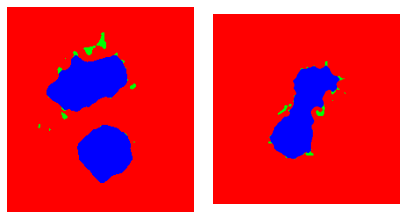

In [124]:
plt.subplot(121)
plt.gca().set_aspect('equal')
plt.axis('off')
plt.imshow(sx1[z])
plt.subplot(122)
plt.gca().set_aspect('equal')
plt.axis('off')
plt.imshow(sx2[z])
plt.tight_layout()
plt.show()

In [129]:
eval(sx1, vy1)
eval(sx2, vy2)
evalw(sx1, vy1, vw1)
evalw(sx2, vy2, vw2)

DC 0.9532862305641174; DCLDC 0.826318621635437
DC 0.9638906121253967; DCLDC 0.8177005052566528
DC 0.05369162932038307; DCLDC 0.04087228327989578
DC 0.08210593461990356; DCLDC 0.10464145988225937


# Segmentation by UNet2D

[42, 21, 3] [106, 102, 3]


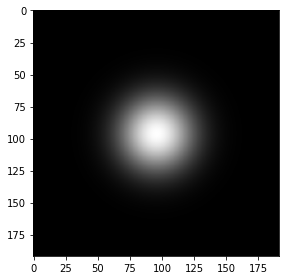

In [3]:
input_shape = [192, 192, 3]
stride1 = list((vx1.shape[1:]) - np.array(input_shape[:-1])) + [3]
stride2 = list((vx2.shape[1:]) - np.array(input_shape[:-1])) + [3]
print(stride1, stride2)

model2D = carreno.nn.unet.UNet(shape=input_shape,
                               n_class=3,
                               depth=4,
                               n_feat=64,
                               dropout=0.3,
                               norm_order='after',
                               activation='relu',
                               top_activation='relu',
                               backbone='vgg16',
                               pretrained=False)


weight = carreno.utils.array.gaussian_kernel(input_shape[:2], sigma=20)
weight = np.stack([weight]*3, axis=-1)

plt.imshow(weight)
plt.show()

In [23]:
# Segmentation by UNet2D
model2D.load_weights(os.path.join(config['DIR']['model'], "unet2dw_optim.h5"))
threshold_unet2D = carreno.pipeline.pipeline.UNet2D(model2D)
sx1 = threshold_unet2D.segmentation(ax1v2, stride1, weight)
sx2 = threshold_unet2D.segmentation(ax2v2, stride2, weight)

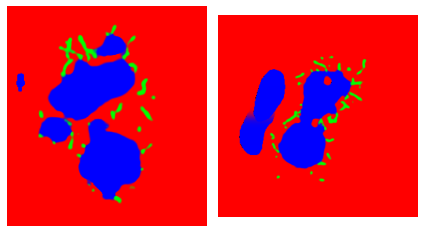

In [5]:
plt.subplot(121)
plt.axis('off')
plt.imshow(sx1[z])
plt.subplot(122)
plt.axis('off')
plt.imshow(sx2[z])
plt.tight_layout()
plt.show()

In [25]:
eval(sx1, vy1)
eval(sx2, vy2)
evalw(sx1, vy1, vw1)
evalw(sx2, vy2, vw2)

DC 0.8882139325141907; DCLDC 0.7325531244277954
DC 0.8728477954864502; DCLDC 0.7188057899475098


InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2]

(192, 192)
(192, 192, 3)
(1, 192, 192, 3) float32
1/1 [==============================] - 0s 24ms/step


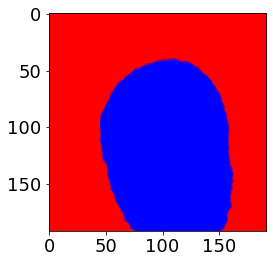

In [65]:
model2D.load_weights("D:/Etude/LINUM/resultat/unet2d_optim_v2/unet2dw_optim.h5")
threshold_unet2D = carreno.pipeline.pipeline.UNet2D(model2D)

patch = ax1[0, :192, :192]
print(patch.shape)
patch = np.stack([patch] * 3, axis=-1)
print(patch.shape)
tmp = np.array([patch])
print(tmp.shape, tmp.dtype)
p = model2D.predict(tmp)
plt.imshow(p[0]); plt.show()

# Segmentation by UNet 3D

[4, 61, 101, 3] [4, 62, 91, 3]


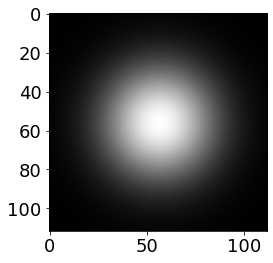

In [233]:
input_shape = [16, 112, 112, 3]
stride1 = [4, 61, 101, 3]
stride2 = [4, 62, 91, 3]
print(stride1, stride2)

model3D = carreno.nn.unet.UNet(shape=input_shape,
                               n_class=3,
                               depth=4,
                               n_feat=64,
                               dropout=0.3,
                               norm_order='after',
                               activation='relu',
                               top_activation='relu',
                               backbone='vgg16',
                               pretrained=False)

weight = carreno.utils.array.gaussian_kernel([112, 16, 112], sigma=20)
weight = np.stack([weight]*3, axis=-1)

plt.imshow(weight[weight.shape[0]//2])
plt.show()

In [237]:
# Segmentation by UNet3D
model3D.load_weights(os.path.join(mod_dir, "unet3dw_optim3.h5"))
threshold_unet3D = carreno.pipeline.pipeline.UNet3D(model3D)
sx1 = threshold_unet3D.segmentation(ax1v2, stride1)
sx2 = threshold_unet3D.segmentation(ax2v2, stride2)

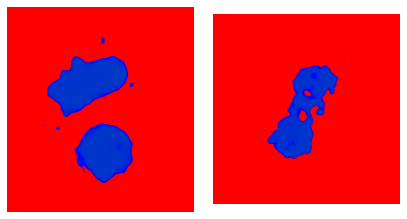

In [238]:
plt.subplot(121)
plt.axis('off')
plt.imshow(np.clip(sx1[z], 0, 1))
plt.subplot(122)
plt.axis('off')
plt.imshow(np.clip(sx2[z], 0, 1))
plt.tight_layout()
plt.show()

In [176]:
print(sx1.shape)
print(sx2.shape)

(58, 233, 212, 3)
(16, 332, 293, 3)


In [206]:
model3D.summary()

Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 16, 112, 11  0           []                               
                                2, 3)]                                                            
                                                                                                  
 conv3d_176 (Conv3D)            (None, 16, 112, 112  5248        ['input_39[0][0]']               
                                , 64)                                                             
                                                                                                  
 conv3d_177 (Conv3D)            (None, 16, 112, 112  110656      ['conv3d_176[1][0]']             
                                , 64)                                                      

In [239]:
# Segmentation by UNet3D
model3D.load_weights(os.path.join(mod_dir, "unet3dw_optim.h5"))
testinp, __, __ = tfs.Standardize().apply(tif.imread("data/dataset/rl_input/ctrl1.tif"))
print(testinp.shape, testinp.dtype)
testinp = np.stack([testinp]*3, axis=-1)
print(testinp.shape, testinp.dtype)
testinp = testinp[:16, :112, :112]
print(testinp.shape, testinp.dtype)
#patch = np.stack([ax1[:16, :112, :112]]*3, axis=-1).astype(np.float32)
#print(patch.shape, patch.dtype)
testout = model3D.predict(np.array([testinp]))
print(testout.shape, testout.dtype)
#plt.imshow(test)

(52, 234, 213) float32
(52, 234, 213, 3) float32
(16, 112, 112, 3) float32
1/1 [==============================] - 0s 31ms/step
(1, 16, 112, 112, 3) float32


(1, 16, 112, 112, 3)


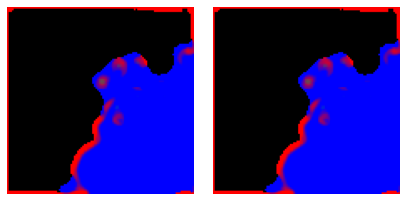

In [240]:
print(testout.shape)
plt.subplot(121)
plt.axis('off')
plt.imshow(testout[0, z])
plt.subplot(122)
plt.axis('off')
plt.imshow(testout[0, z])
plt.tight_layout()
plt.show()

[4, 61, 101, 3] [4, 62, 91, 3]


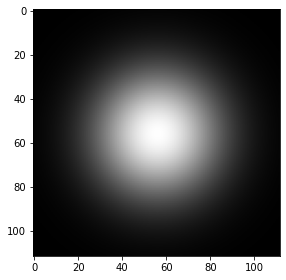

In [6]:
input_shape = [16, 112, 112, 3]
stride1 = [4, 61, 101, 3]
stride2 = [4, 62, 91, 3]
print(stride1, stride2)

model3D = carreno.nn.unet.UNet(shape=input_shape,
                               n_class=3,
                               depth=4,
                               n_feat=64,
                               dropout=0.3,
                               norm_order='before',
                               activation='relu',
                               top_activation='softmax',
                               backbone=None,
                               pretrained=False)

weight = carreno.utils.array.gaussian_kernel([112, 16, 112], sigma=20)
weight = np.stack([weight]*3, axis=-1)

plt.imshow(weight[weight.shape[0]//2])
plt.show()

In [7]:
# Segmentation by UNet3D
model3D.load_weights(os.path.join(mod_dir, "unet3dw_base.h5"))
threshold_unet3D = carreno.pipeline.pipeline.UNet3D(model3D)
sx1 = threshold_unet3D.segmentation(ax1v2, stride1)
sx2 = threshold_unet3D.segmentation(ax2v2, stride2)
plt.subplot(121)
plt.axis('off')
plt.imshow(np.clip(sx1[z], 0, 1))
plt.subplot(122)
plt.axis('off')
plt.imshow(np.clip(sx2[z], 0, 1))
plt.tight_layout()
plt.show()

ValueError: axes don't match array

In [221]:
inp_dir = config['VOLUME']['rl_input']
for f in os.listdir(inp_dir):
    of = tif.imread(os.path.join(inp_dir, f))
    print(os.path.join(inp_dir, f), of.shape, of.dtype)


data/dataset/rl_input\ctrl1.tif (52, 234, 213) float32
data/dataset/rl_input\ctrl2.tif (52, 293, 423) float32
data/dataset/rl_input\ctrl3.tif (39, 200, 240) float32
data/dataset/rl_input\ctrl4.tif (39, 341, 330) float32
data/dataset/rl_input\slik1.tif (52, 298, 294) float32
data/dataset/rl_input\slik2.tif (52, 282, 294) float32
data/dataset/rl_input\slik3.tif (39, 235, 297) float32
data/dataset/rl_input\slik4.tif (38, 309, 367) float32
data/dataset/rl_input\slik5.tif (39, 422, 370) float32
data/dataset/rl_input\slik6.tif (39, 344, 360) float32
